In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from emnist import get_emnist_data_loaders
train_loader, val_loader, test_loader = get_emnist_data_loaders()

In [10]:
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
import torch.nn as nn
from training.trainer import Trainer
import hyperparameter as hp
import torch
from evaluation.loss import plot_loss


crnn = CRNN(hp.GRU_HIDDEN_SIZE, hp.GRU_NUM_LAYERS, hp.NUM_CLASSES, hp.CNN_OUTPUT_HEIGHT)
lstm = CNN_LSTM(hp.GRU_HIDDEN_SIZE, hp.GRU_NUM_LAYERS, hp.NUM_CLASSES, hp.CNN_OUTPUT_HEIGHT)

models = {
    "crnn": crnn,
    "lstm_cnn": lstm
}

crnn_criterion = nn.CTCLoss(blank=hp.BLANK_LABEL, reduction='mean', zero_infinity=True)
lstm_criterion = nn.CTCLoss(blank=hp.BLANK_LABEL, reduction='mean', zero_infinity=True)

criterions = {
    "crnn": crnn_criterion,
    "lstm_cnn": lstm_criterion
}

crnn_optimizer = torch.optim.Adam(crnn.parameters(), lr=hp.LEARNING_RATE)
lstm_optimizer = torch.optim.Adam(lstm.parameters(), lr=hp.LEARNING_RATE)

optimizers = {
    "crnn": crnn_optimizer,
    "lstm_cnn": lstm_optimizer
}

crnn_trainer = Trainer(models["crnn"], criterions["crnn"], optimizers["crnn"], train_loader, val_loader,test_loader, epochs=hp.EPOCHS, args={
        "blank_label": hp.BLANK_LABEL,
        "cnn_output_width": hp.CNN_OUTPUT_WIDTH,
    })
lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, test_loader, epochs=hp.EPOCHS, args={
        "blank_label": hp.BLANK_LABEL,
        "cnn_output_width": hp.CNN_OUTPUT_WIDTH,
    })
trainers = {
    "crnn": crnn_trainer,
    "lstm_cnn": lstm_trainer
}


In [11]:
metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    metrics = trainer.train_validate_test()
    metrics_global[model_name] = metrics
    print(f"Finished training {model_name}")

    # Save the trained model
    torch.save(trainer.model.state_dict(), 'models/' + model_name + '/model.pth')

Training crnn
  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:31<00:00,  3.54it/s]
EPOCH 1/10 - TRAINING. Correct: 0/7000 = 0.0000 - Average CER Score: 0.976
100%|██████████| 2999/2999 [00:11<00:00, 264.91it/s]

/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/leonremke/opt/anaconda3/envs/DSTA-Ex/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



EPOCH 1/10 - TESTING. Correct: 4/2999 = 0.0013 - Average CER Score: nan
100%|██████████| 110/110 [00:30<00:00,  3.59it/s]
EPOCH 2/10 - TRAINING. Correct: 3345/7000 = 0.4779 - Average CER Score: 0.626
100%|██████████| 2999/2999 [00:13<00:00, 230.35it/s]
EPOCH 2/10 - TESTING. Correct: 2264/2999 = 0.7549 - Average CER Score: nan
100%|██████████| 110/110 [00:31<00:00,  3.45it/s]
EPOCH 3/10 - TRAINING. Correct: 5620/7000 = 0.8029 - Average CER Score: 0.416
100%|██████████| 2999/2999 [00:11<00:00, 266.98it/s]
EPOCH 3/10 - TESTING. Correct: 2481/2999 = 0.8273 - Average CER Score: nan
100%|██████████| 110/110 [00:30<00:00,  3.57it/s]
EPOCH 4/10 - TRAINING. Correct: 6128/7000 = 0.8754 - Average CER Score: 0.313
100%|██████████| 2999/2999 [00:11<00:00, 265.08it/s]
EPOCH 4/10 - TESTING. Correct: 2586/2999 = 0.8623 - Average CER Score: nan
100%|██████████| 110/110 [00:31<00:00,  3.54it/s]
EPOCH 5/10 - TRAINING. Correct: 6394/7000 = 0.9134 - Average CER Score: 0.251
100%|██████████| 2999/2999 [00:

In [12]:
for model_name, model in models.items():
    # Load model

    base_path = 'models/' + model_name + "/"
    model_path = base_path + 'model.pth'
    model = model.to("cpu")
    model.load_state_dict(torch.load(model_path))

    # Plot the trained model
    plot_loss(model_name=model_name, train_loss_per_epoch=trainer.epoch_train_cers, val_loss_per_epoch=trainer.epoch_val_cers, figure_evaluation_dir=base_path)

models/crnn/crnn_loss.png
models/lstm_cnn/lstm_cnn_loss.png


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [13]:
lstm_trainer.load_model('models/lstm_cnn/model.pth')
lstm_trainer.test(plot_n=1)


100%|██████████| 1/1 [00:00<00:00, 184.91it/s]


AttributeError: 'Trainer' object has no attribute 'epoch_test_cers'

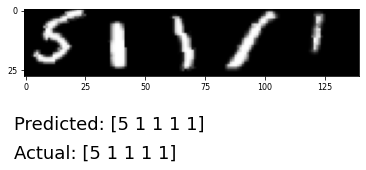

In [ ]:
crnn_trainer.load_model('models/crnn/model.pth')
crnn_trainer.test(plot_n=1)
